# 1. The Continuous bag of words model

In [3]:
# Import Python libraries and helper functions (in utils2) 
import nltk
from nltk.tokenize import word_tokenize
import numpy as np
from collections import Counter

from utils2 import sigmoid, get_batches, compute_pca, get_dict

In [6]:
# Download sentence tokenizer
nltk.data.path.append('.')
nltk.download("punkt")

[nltk_data] Downloading package punkt to /home/surajkarki/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [10]:
# Load, tokenize and process the data
import re                                                           #  Load the Regex-modul
with open('shakespeare.txt') as f:
    data = f.read()                                                 #  Read in the data
data = re.sub(r'[,!?;-]', '.',data)                                 #  Punctuations are replaced by .
data = nltk.word_tokenize(data)                                     #  Tokenize string to words
data = [ ch.lower() for ch in data if ch.isalpha() or ch == '.']    #  Lower case and drop non-alphabetical tokens
print("Number of tokens:", len(data),'\n', data[:15])               #  print data sample

Number of tokens: 60996 
 ['o', 'for', 'a', 'muse', 'of', 'fire', '.', 'that', 'would', 'ascend', 'the', 'brightest', 'heaven', 'of', 'invention']


In [11]:
# Compute the frequency distribution of the words in the dataset (vocabulary)
fdist = nltk.FreqDist(word for word in data)
print("Size of vocabulary: ",len(fdist) )
print("Most frequent tokens: ",fdist.most_common(20) ) # print the 20 most frequent words and their freq.

Size of vocabulary:  5778
Most frequent tokens:  [('.', 9630), ('the', 1521), ('and', 1394), ('i', 1257), ('to', 1159), ('of', 1093), ('my', 857), ('that', 781), ('in', 770), ('a', 752), ('you', 748), ('is', 630), ('not', 559), ('for', 467), ('it', 460), ('with', 441), ('his', 434), ('but', 417), ('me', 417), ('your', 397)]


#### Mapping words to indices and indices to words
We provide a helper function to create a dictionary that maps words to indices and indices to words.

In [12]:
# get_dict creates two dictionaries, converting words to indices and viceversa.
word2Ind, Ind2word = get_dict(data)
V = len(word2Ind)
print("Size of vocabulary: ", V)

Size of vocabulary:  5778


In [13]:
# example of word to index mapping
print("Index of the word 'king' :  ",word2Ind['king'] )
print("Word which has index 2743:  ",Ind2word[2743] )

Index of the word 'king' :   2745
Word which has index 2743:   kindness


# 2 Training the Model

###  Initializing the model

You will now initialize two matrices and two vectors. 
- The first matrix ($W_1$) is of dimension $N \times V$, where $V$ is the number of words in your vocabulary and $N$ is the dimension of your word vector.
- The second matrix ($W_2$) is of dimension $V \times N$. 
- Vector $b_1$ has dimensions $N\times 1$
- Vector $b_2$ has dimensions  $V\times 1$. 
- $b_1$ and $b_2$ are the bias vectors of the linear layers from matrices $W_1$ and $W_2$.

<a name='ex-01'></a>

In [14]:
def initialize_model(N,V, random_seed=1):
    '''
    Inputs: 
        N:  dimension of hidden vector 
        V:  dimension of vocabulary
        random_seed: random seed for consistent results in the unit tests
     Outputs: 
        W1, W2, b1, b2: initialized weights and biases
    '''
    
    np.random.seed(random_seed)
    
    # W1 has shape (N,V)
    W1 = np.random.rand(N, V)
    # W2 has shape (V,N)
    W2 = np.random.rand(V, N)
    # b1 has shape (N,1)
    b1 = np.random.rand(N, 1)
    # b2 has shape (V,1)
    b2 = np.random.rand(V, 1)

    return W1, W2, b1, b2

In [15]:
tmp_N = 4
tmp_V = 10
tmp_W1, tmp_W2, tmp_b1, tmp_b2 = initialize_model(tmp_N,tmp_V)
assert tmp_W1.shape == ((tmp_N,tmp_V))
assert tmp_W2.shape == ((tmp_V,tmp_N))
print(f"tmp_W1.shape: {tmp_W1.shape}")
print(f"tmp_W2.shape: {tmp_W2.shape}")
print(f"tmp_b1.shape: {tmp_b1.shape}")
print(f"tmp_b2.shape: {tmp_b2.shape}")

tmp_W1.shape: (4, 10)
tmp_W2.shape: (10, 4)
tmp_b1.shape: (4, 1)
tmp_b2.shape: (10, 1)


<a name='2.1'></a>
### 2.1 Softmax
Before we can start training the model, we need to implement the softmax function as defined in equation 5:  

<br>
$$ \text{softmax}(z_i) = \frac{e^{z_i} }{\sum_{i=0}^{V-1} e^{z_i} }  \tag{5} $$

- Array indexing in code starts at 0.
- $V$ is the number of words in the vocabulary (which is also the number of rows of $z$).
- $i$ goes from 0 to |V| - 1.


<a name='ex-02'></a>

In [16]:
def softmax(z):
    '''
    Inputs: 
        z: output scores from the hidden layer
    Outputs: 
        yhat: prediction (estimate of y)
    '''
    # Calculate yhat (softmax)
    yhat = np.exp(z) / np.sum(np.exp(z), axis = 0)
    
    return yhat

In [17]:
tmp = np.array([[1,2,3],
                [1,1,1]
               ])
tmp_sm = softmax(tmp)
display(tmp_sm)

array([[0.5       , 0.73105858, 0.88079708],
       [0.5       , 0.26894142, 0.11920292]])

### 2.2 Forward propagation

In [18]:
# UNQ_C3 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
# GRADED FUNCTION: forward_prop
def forward_prop(x, W1, W2, b1, b2):
    '''
    Inputs: 
        x:  average one hot vector for the context 
        W1, W2, b1, b2:  matrices and biases to be learned
     Outputs: 
        z:  output score vector
    '''
    
    # Calculate h
    h = np.dot(W1, x) + b1
    
    # Apply the relu on h (store result in h)
    h = np.maximum(0, h)
    
    # Calculate z
    z = np.dot(W2, h) + b2

    return z, h

In [19]:
# Test the function

# Create some inputs
tmp_N = 2
tmp_V = 3
tmp_x = np.array([[0,1,0]]).T
tmp_W1, tmp_W2, tmp_b1, tmp_b2 = initialize_model(N=tmp_N,V=tmp_V, random_seed=1)

print(f"x has shape {tmp_x.shape}")
print(f"N is {tmp_N} and vocabulary size V is {tmp_V}")

# call function
tmp_z, tmp_h = forward_prop(tmp_x, tmp_W1, tmp_W2, tmp_b1, tmp_b2)
print("call forward_prop")
print()
# Look at output
print(f"z has shape {tmp_z.shape}")
print("z has values:")
print(tmp_z)

print()

print(f"h has shape {tmp_h.shape}")
print("h has values:")
print(tmp_h)

x has shape (3, 1)
N is 2 and vocabulary size V is 3
call forward_prop

z has shape (3, 1)
z has values:
[[0.55379268]
 [1.58960774]
 [1.50722933]]

h has shape (2, 1)
h has values:
[[0.92477674]
 [1.02487333]]


<a name='2.3'></a>
## 2.3 Cost function

In [20]:
# compute_cost: cross-entropy cost functioN
def compute_cost(y, yhat, batch_size):
    # cost function 
    logprobs = np.multiply(np.log(yhat),y) + np.multiply(np.log(1 - yhat), 1 - y)
    cost = - 1/batch_size * np.sum(logprobs)
    cost = np.squeeze(cost)
    return cost

<a name='2.4'></a>
## 2.4 Training the Model - Backpropagation

In [21]:
def back_prop(x, yhat, y, h, W1, W2, b1, b2, batch_size):
    '''
    Inputs: 
        x:  average one hot vector for the context 
        yhat: prediction (estimate of y)
        y:  target vector
        h:  hidden vector (see eq. 1)
        W1, W2, b1, b2:  matrices and biases  
        batch_size: batch size 
     Outputs: 
        grad_W1, grad_W2, grad_b1, grad_b2:  gradients of matrices and biases   
    '''
    
    # Compute l1 as W2^T (Yhat - Y)
    # Re-use it whenever you see W2^T (Yhat - Y) used to compute a gradient
    l1 = np.dot(W2.T, yhat - y)
    # Apply relu to l1
    l1 = np.maximum(0, l1)
    # Compute the gradient of W1
    grad_W1 = np.dot(l1, x.T) / batch_size
    # Compute the gradient of W2
    grad_W2 = np.dot(yhat - y, h.T) / batch_size
    # Compute the gradient of b1
    grad_b1 = np.sum(l1, axis = 1, keepdims = True) / batch_size
    # Compute the gradient of b2
    grad_b2 = np.sum(yhat - y, axis = 1, keepdims = True) / batch_size
    
    return grad_W1, grad_W2, grad_b1, grad_b2

<a name='2.5'></a>
## Gradient Descent

In [24]:
def gradient_descent(data, word2Ind, N, V, num_iters, alpha=0.03):
    
    '''
    This is the gradient_descent function
    
      Inputs: 
        data:      text
        word2Ind:  words to Indices
        N:         dimension of hidden vector  
        V:         dimension of vocabulary 
        num_iters: number of iterations  
     Outputs: 
        W1, W2, b1, b2:  updated matrices and biases   

    '''
    W1, W2, b1, b2 = initialize_model(N,V, random_seed=282)
    batch_size = 128
    iters = 0
    C = 2
    for x, y in get_batches(data, word2Ind, V, C, batch_size):
        # Get z and h
        z, h = forward_prop(x, W1, W2, b1, b2)
        # Get yhat
        yhat = softmax(z)
        # Get cost
        cost = compute_cost(y, yhat, batch_size)
        if ( (iters+1) % 10 == 0):
            print(f"iters: {iters + 1} cost: {cost:.6f}")
            
        # Get gradients
        grad_W1, grad_W2, grad_b1, grad_b2 = back_prop(x, yhat, y, h, W1, W2, b1, b2, batch_size)
        
        # Update weights and biases
        W1 = W1 - alpha * grad_W1
        W2 = W2 - alpha * grad_W2
        b1 = b1 - alpha * grad_b1
        b2 = b2 - alpha * grad_b2
        
        
        iters += 1 
        if iters == num_iters: 
            break
        if iters % 100 == 0:
            alpha *= 0.66
            
    return W1, W2, b1, b2

In [25]:
C = 2
N = 50
word2Ind, Ind2word = get_dict(data)
V = len(word2Ind)
num_iters = 150
print("Call gradient_descent")
W1, W2, b1, b2 = gradient_descent(data, word2Ind, N, V, num_iters)

Call gradient_descent
iters: 10 cost: 0.789141
iters: 20 cost: 0.105543
iters: 30 cost: 0.056008
iters: 40 cost: 0.038101
iters: 50 cost: 0.028868
iters: 60 cost: 0.023237
iters: 70 cost: 0.019444
iters: 80 cost: 0.016716
iters: 90 cost: 0.014660
iters: 100 cost: 0.013054
iters: 110 cost: 0.012133
iters: 120 cost: 0.011370
iters: 130 cost: 0.010698
iters: 140 cost: 0.010100
iters: 150 cost: 0.009566


<a name='3'></a>
## 3.0 Visualizing the word vectors

In [26]:
# visualizing the word vectors here
from matplotlib import pyplot
%config InlineBackend.figure_format = 'svg'
words = ['king', 'queen','lord','man', 'woman','dog','horse',
         'rich','happy','sad']

embs = (W1.T + W2)/2.0
 
# given a list of words and the embeddings, it returns a matrix with all the embeddings
idx = [word2Ind[word] for word in words]
X = embs[idx, :]
print(X.shape, idx)  # X.shape:  Number of words of dimension N each 

(10, 50) [2745, 3951, 2961, 3023, 5675, 1452, 2472, 4191, 2316, 4278]


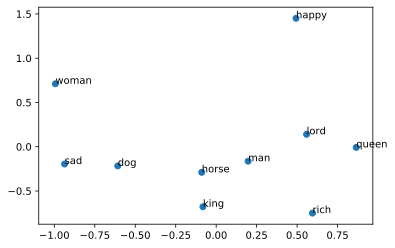

In [27]:
result= compute_pca(X, 2)
pyplot.scatter(result[:, 0], result[:, 1])
for i, word in enumerate(words):
    pyplot.annotate(word, xy=(result[i, 0], result[i, 1]))
pyplot.show()

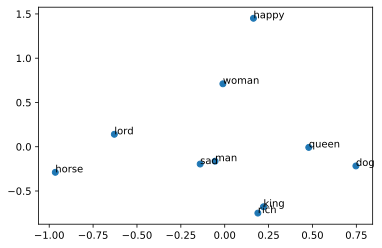

In [28]:
result= compute_pca(X, 4)
pyplot.scatter(result[:, 3], result[:, 1])
for i, word in enumerate(words):
    pyplot.annotate(word, xy=(result[i, 3], result[i, 1]))
pyplot.show()

In [33]:
embs[0].shape

(50,)